In [1]:
# !apt-get install -y libsndfile1

In [2]:
!pip install --upgrade librosa soundfile
!pip install transformers torch torchaudio

!pip install PySoundFile
!pip install scikit-maad
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.2/167.2 kB 4.8 MB/s eta 0:00:00


In [3]:
# ===== SETUP AND DATA PIPELINE =====

# 1. IMPORTS

# Core ML & GPU
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from torch.utils.data import Dataset

#from keras.callbacks import EarlyStopping

import torch
import torchaudio
from transformers import ASTConfig, ASTForAudioClassification, ASTFeatureExtractor

# scikit-learn maad for when u want to grrr
from maad import sound, features as maad_features

from huggingface_hub import login

# Dataloading
import numpy as np
import pandas as pd
import librosa
import librosa.display
import os
import glob #for finding TFRecord files

# Colab specific
from google.colab import drive, userdata

from tqdm.auto import tqdm

import plotly.express as px

# Utilities
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 2. MOUNT & UNZIP

drive.mount('/content/drive')

ZIP_FILE_PATH = "/content/drive/MyDrive/rfcx-species-audio-detection.zip"

UNZIP_DESTINATION = "/content/rfcx_local_data/"

print(f"Unzupping {ZIP_FILE_PATH} to {UNZIP_DESTINATION} . . . ")
os.makedirs(UNZIP_DESTINATION, exist_ok=True)

!unzip -q -o "{ZIP_FILE_PATH}" -d "{UNZIP_DESTINATION}"

print("I took the zip and I unzipped the zip so now the zip is unzipped and ready")


Mounted at /content/drive
Unzupping /content/drive/MyDrive/rfcx-species-audio-detection.zip to /content/rfcx_local_data/ . . . 
I took the zip and I unzipped the zip so now the zip is unzipped and ready


In [4]:
# 3. CONFIG & PATHS

# run into an error here

BATCH_SIZE = 32
DRIVE_FLAC_PATH = "/content/rfcx_local_data/rfcx-species-audio-detection/train/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 4. FEATURE EXTRACTOR
checkpoint = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = ASTFeatureExtractor.from_pretrained(checkpoint)

# 5. ROBUST ADI CALCULATION FUNCTION
def calculate_robust_adi(audio, sr, n_fft=2048, hop_length=512, fmin=2000.0, fmax=8000.0, bin_step=200.0):
  try:
    # 1. Calculate power spectrogramBE
    S = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))**2

    # 2. Convert to dB
    S_db = librosa.power_to_db(S, ref=np.max)

    # BACKGROUND SUBTRACTION
    # calculate median spectrum ("constant drone") across time; axis=1 is time
    background_profile = np.median(S_db, axis=1, keepdims=True)

    # subtract background: constant approaches 0, calls (transient) are scored
    S_db_clean = S_db - background_profile

    # 3. Thresholding (relative)
    # only count bins that "pop" above background by X dB
    # 10dB is solid standard for "distinct call"
    # 17dB was too harsh, lowering to 10dB
    active_bins = S_db_clean > 13.5

    # 4. frequency band logic (absolute approach)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    freq_bins = np.arange(fmin, fmax + bin_step, bin_step)
    n_bands = len(freq_bins) - 1

    if n_bands <= 0:
      return np.float32(0.0)

    props = []

    for i in range(n_bands):
      f_low = freq_bins[i]
      f_high = freq_bins[i+1]

      # get indices for this band
      band_indices = np.where((freqs >= f_low) & (freqs < f_high))[0]

      if len(band_indices) == 0:
        props.append(0.0)
        continue

      # get the binary "active" map for this band
      band_activity = active_bins[band_indices, :]

      # calculate proportion of active time-frequency cells
      # rewards bands with lots of distinct calls (high variability)
      # penalized constant rain (subtracted to 0)
      proportion = np.mean(band_activity)
      props.append(proportion)

    # 5. shannon entropy calculation
    props = np.array(props)
    # filter silent bands to avoid log(0)
    props = props[props > 0]

    # === *DYNAMIC* SOFT FALLBACK TO AVOID 0.0 CRUSH ===
    if len(props) == 0:
      # if n_bands = 0 were lit up, fallback to score lesser based on energy in range

      total_energy = np.sum(S_db_clean[S_db_clean > 0])

      # # 100 is very low bar for total energy in 10s, if signal return epsilon (0.01)
      # if total_energy > 100.0:
      #   return np.float32(0.01)
      # else:
      #   return np.float32(0.0)

      dynamic_score = np.interp(total_energy, [0, 2000], [0.0, 0.05])

      return np.float32(dynamic_score)

    # normalize to create a probability distribution
    props_norm = props / np.sum(props)

    # entropy
    adi_score = -np.sum(props_norm * np.log(props_norm))

    # normalize by max possible entropy (log of number of bands)
    normalized_adi = adi_score / np.log(n_bands)

    return np.float32(np.clip(normalized_adi, 0.0, 1.0))

  except Exception as e:
    print(f"Error: {e}")
    return np.float32(0.0)

# 6. DATALOADER (Hybrid TF-PyTorch)
# hides block of up to 15/128 of frequency bands
freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=15)
# hides block of up to 50/1024 of time frame
time_masking = torchaudio.transforms.TimeMasking(time_mask_param=50)

def load_and_process_from_path(file_path_tensor, augment=False):

  def _process_audio_file(file_path):
    path = file_path.numpy().decode('utf-8')

    if augment:
      random_offset = np.random.uniform(0, 48.0)
    else:
      random_offset = 0.0

    # 1. load raw audio
    audio, sr = librosa.load(path, sr=16000, offset=random_offset, duration=10.24)

    # pad if short
    target_len = 16000 * 10.24
    if len(audio) < target_len:
      audio = np.pad(audio, (0, int(target_len - len(audio))))
    else:
      audio = audio[:int(target_len)]

    # 2. use feature extractor, so data looks exactly like the data model trained on
    inputs = feature_extractor(
        audio,
        sampling_rate=16000,
        return_tensors="pt"
    )

    # AST expects [time_frame, frequency_bins]
    input_values = inputs['input_values']

    if input_values.ndim == 2:
      input_values = input_values.unsqueeze(0)

    if augment:
      input_values = input_values.permute(0, 2, 1) # [Batch, Freq, Time]
      input_values = freq_masking(input_values)
      input_values = time_masking(input_values)
      input_values = input_values.permute(0, 2, 1)

    if input_values.shape[0] == 1:
      input_values = input_values.squeeze(0)

    input_values = input_values.numpy()

    # CNN FIX
    tf_input = tf.convert_to_tensor(input_values)

    tf_input = tf.expand_dims(tf_input, -1)

    tf_input = tf.image.resize(tf_input, [224, 224])

    tf_input = tf.image.grayscale_to_rgb(tf_input)

    input_values = tf_input.numpy()

    # 3. calcualte real DI
    raw_adi = calculate_robust_adi(audio, sr)

    return input_values.astype(np.float32), np.float32(raw_adi)

  # wrapper to make it work in TF graph
  features, label = tf.py_function(
      func=_process_audio_file,
      inp=[file_path_tensor],
      Tout=[tf.float32, tf.float32]
  )

  features.set_shape([224, 224, 3])
  label.set_shape([])

  return features, label

Using device: cuda


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [5]:
# ===== DATASET SPLIT & CALIBRATION =====

# 7. DATASET SPLIT & CALIBRATION

BATCH_SIZE = 16

DRIVE_FLAC_PATH = "/content/rfcx_local_data/rfcx-species-audio-detection/train/"

print(f"Loading files from: {DRIVE_FLAC_PATH}")
all_flac_files = sorted(glob.glob(DRIVE_FLAC_PATH + "*.flac"))

split_point = int(len(all_flac_files) * 0.8)
train_files = all_flac_files[:split_point]
val_files = all_flac_files[split_point:]

print("I'm done and im saying this so you know i'm not still going at it")


Loading files from: /content/rfcx_local_data/rfcx-species-audio-detection/train/
I'm done and im saying this so you know i'm not still going at it


In [6]:
# ADI Calibration pass

import soundfile as sf

# silent_audio = np.zeros(16000*60, dtype=np.float32)
# blank_path = "/content/drive/MyDrive/rfcx-species-audio-detection/blank.flac"

# sf.write(blank_path, silent_audio, 16000)
# print(f"Created new blank file at {blank_path}")

anchor_files = [
    "/content/drive/MyDrive/rfcx-species-audio-detection/blank.flac",
    "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/airport_baggage.flac",
    "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/bowling_alley.flac",
    "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/bus.flac",
    "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/laundromat.flac",
    "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/subway.flac",
    "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/urban_park_birds.flac",
    "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/wind_stairwell.flac",
]

calibration_file_list = train_files + anchor_files

print(f"Calibrating adi scores across {len(calibration_file_list)} total files . . .")

cal_paths_ds = tf.data.Dataset.from_tensor_slices(calibration_file_list)
cal_ds_for_adi_only = cal_paths_ds.map(load_and_process_from_path, num_parallel_calls=tf.data.AUTOTUNE)


cal_ds_zipped = tf.data.Dataset.zip((cal_ds_for_adi_only, cal_paths_ds))

print("Iterating and pairing adi scores with filenames . . .")
adi_data = []

for (features, label), path in tqdm(cal_ds_zipped, total=len(calibration_file_list)):
  adi_data.append((path.numpy().decode('utf-8'), label.numpy()))

df_adi = pd.DataFrame(adi_data, columns=['filename', 'raw_adi'])

print("\n--- ADI Score Analysis ---")

pd.set_option('display.max_colwidth', None)

print(df_adi.sort_values(by='raw_adi', ascending=False).head(5))

adi_scores = df_adi['raw_adi'].values

min_adi = np.min(adi_scores)
max_adi = np.max(adi_scores)
print(f"Calibration done. Min ADI: {min_adi:.4f}, Max ADI: {max_adi:.4f}")

all_normalized_scores = (adi_scores - min_adi) / (max_adi - min_adi + 1e-10)
all_normalized_scores = np.clip(all_normalized_scores, 0.0, 1.0)

def normalize_label(features, raw_adi_label):
  normalized_label = (raw_adi_label - min_adi) / (max_adi - min_adi + 1e-10)
  normalized_label = tf.clip_by_value(normalized_label, 0.0, 1.0)
  return features, normalized_label

print("Building training dataset (from Amazon files only) . . .")

train_paths_ds = tf.data.Dataset.from_tensor_slices(calibration_file_list)

# train_ds = (
#     train_paths_ds.map(load_and_process_from_path, num_parallel_calls=tf.data.AUTOTUNE)
#     .map(normalize_label, num_parallel_calls=tf.data.AUTOTUNE)
#     .cache()
#     .shuffle(1024)
#     .batch(BATCH_SIZE)
#     .prefetch(tf.data.AUTOTUNE)
# )

train_ds = (
    train_paths_ds.map(lambda x: load_and_process_from_path(x, augment=True),
                       num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("Buuilding validation dataset . . .")
val_paths_ds = tf.data.Dataset.from_tensor_slices(val_files)
val_ds = (
    val_paths_ds.map(load_and_process_from_path, num_parallel_calls=tf.data.AUTOTUNE)
    #.map(normalize_label, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("\n--- Final Dataset Test ---")
for features, labels in train_ds.take(1):
  print("Data pipeline working with .flac files and normalized ADI (with Domain Adaptation)!")
  print("Features shape:", features.shape)
  print("Example Normalized ADI scores:", labels.numpy()[:5])

Calibrating adi scores across 3789 total files . . .
Iterating and pairing adi scores with filenames . . .


  0%|          | 0/3789 [00:00<?, ?it/s]


--- ADI Score Analysis ---
                                                                        filename  \
2086  /content/rfcx_local_data/rfcx-species-audio-detection/train/7147c1869.flac   
899   /content/rfcx_local_data/rfcx-species-audio-detection/train/2faacd5e0.flac   
3429  /content/rfcx_local_data/rfcx-species-audio-detection/train/b9d78a899.flac   
2491  /content/rfcx_local_data/rfcx-species-audio-detection/train/866f256d7.flac   
2782  /content/rfcx_local_data/rfcx-species-audio-detection/train/9683e1e95.flac   

       raw_adi  
2086  0.994467  
899   0.994029  
3429  0.993173  
2491  0.992570  
2782  0.992135  
Calibration done. Min ADI: 0.0000, Max ADI: 0.9945
Building training dataset (from Amazon files only) . . .
Buuilding validation dataset . . .

--- Final Dataset Test ---
Data pipeline working with .flac files and normalized ADI (with Domain Adaptation)!
Features shape: (16, 224, 224, 3)
Example Normalized ADI scores: [0.89527106 0.96647567 0.6060648  0.8743453  

Mean ADI: 0.7611
Median ADI: 0.7807


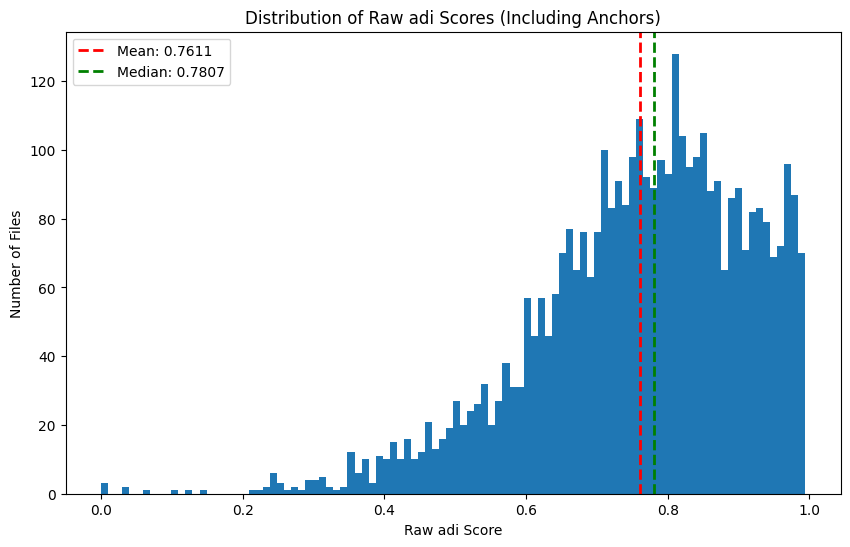

In [7]:
# PLOT THE DISTRIBUTION OF ADI SCORES ACROSS DATASET

print(f"Mean ADI: {np.mean(adi_scores):.4f}")
print(f"Median ADI: {np.median(adi_scores):.4f}")

plt.figure(figsize=(10, 6))
plt.hist(adi_scores, bins=100)
plt.title('Distribution of Raw adi Scores (Including Anchors)')
plt.xlabel('Raw adi Score')
plt.ylabel('Number of Files')
plt.axvline(np.mean(adi_scores), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(adi_scores):.4f}')
plt.axvline(np.median(adi_scores), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(adi_scores):.4f}')
plt.legend()
plt.show()

fig = px.histogram(all_normalized_scores, nbins=100, title="Distribution of Final Normalized ADI Scores (Training Set)")
fig.show()

In [8]:
#DEFINE CNN MODEL / call model, model / use tensorflow / 8 layer conv, lots of params /
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_dir = "/content/drive/MyDrive/Bioacoustics/checkpoints/"
os.makedirs(checkpoint_dir, exist_ok=True)
best_model_path = os.path.join(checkpoint_dir, "best_cnn_model.keras")

#CNN model for regression biodiversity score
def make_cnn(input_shape=(224, 224, 3), l2=1e-4, drop=0.25):
    inputs = layers.Input(shape=input_shape)

    # normalize pixels to [0,1]
    #x = layers.Rescaling(1./255)(inputs)


    # Block 1
    x = layers.Conv2D(32, 3, padding="same", kernel_regularizer=regularizers.l2(l2))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, padding="same", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(drop)(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding="same", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, padding="same", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(drop)(x)

    # Block 3
    x = layers.Conv2D(128, 3, padding="same", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 3, padding="same", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(drop)(x)
#Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="linear", name="biodiversity_score")(x)

    return Model(inputs, outputs, name="biodiversity_model")

#build it
model = make_cnn(input_shape=(224, 224, 3))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mae']
)

print('\n Ayo son we got it, the CNN model is build correctly and im ready to pull it')

callbacks = [
    ModelCheckpoint(best_model_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
]

dummy_input = tf.ones((1, 224, 224, 3))
model(dummy_input)
model.summary()


 Ayo son we got it, the CNN model is build correctly and im ready to pull it


Model: "biodiversity_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 322,081 (1.23 MB)

 Trainable params: 321,185 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)

In [9]:
#run into an error here

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=75,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/75
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.2755 - mae: 0.2393
Epoch 1: val_loss improved from inf to 0.33651, saving model to /content/drive/MyDrive/Bioacoustics/checkpoints/best_cnn_model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 120s 359ms/step - loss: 0.2752 - mae: 0.2390 - val_loss: 0.3365 - val_mae: 0.3026 - learning_rate: 0.0010
Epoch 2/75
236/237 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.1620 - mae: 0.1293
Epoch 2: val_loss improved from 0.33651 to 0.15574, saving model to /content/drive/MyDrive/Bioacoustics/checkpoints/best_cnn_model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 225ms/step - loss: 0.1620 - mae: 0.1292 - val_loss: 0.1557 - val_mae: 0.1265 - learning_rate: 0.0010
Epoch 3/75
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.1499 - mae: 0.1220
Epoch 3: val_loss improved from 0.15574 to 0.12073, saving model to /content/drive/MyDrive/Bioacoustics/checkpoints/best_cnn_model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 73s 228ms/step - loss: 0.1499 - mae: 0.1219 - 

In [13]:
# run into an error here

model.load_weights(best_model_path)

In [14]:
TEST_FLAC_PATH = "/content/rfcx_local_data/rfcx-species-audio-detection/test/"
test_files = sorted(glob.glob(TEST_FLAC_PATH + "*.flac"))

test_paths_ds = tf.data.Dataset.from_tensor_slices(test_files)
test_ds = (
    test_paths_ds.map(load_and_process_from_path, num_parallel_calls=tf.data.AUTOTUNE)
    .map(normalize_label, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

results = model.evaluate(test_ds)

print("\n--- Test Results ---")
print(f"Test Loss (MAE): {results[0]:.4f}")
print(f"Test Metric (RMSE): {results[1]:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 267ms/step - loss: 0.0664 - mae: 0.0629

--- Test Results ---
Test Loss (MAE): 0.0668
Test Metric (RMSE): 0.0634


Running full prediction loop to get labels and predictions . . .
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Files with big boy scores:
                                                                       filename  \
31   /content/rfcx_local_data/rfcx-species-audio-detection/train/cf3f3b9be.flac   
567  /content/rfcx_local_data/rfcx-species-audio-detection/train/eb685f870.flac   
33   /content/rfcx_local_data/rfcx-species-audio-detection/train/cf4dee5dc.flac   
319  /content/rfcx_local_data/rfcx-species-audio-detection/train/de0c8a7f7.flac   
492  /content/rfcx_local_data/rfcx-species-audio-detection/train/e744f47c3.flac   

     true_score  pred_score  
31     0.983494    1.079160  
567    0.973254    1.042089  
33     0.983917    1.035974  
319    0.970799    1.023966  
492    0.946565    1.013783  

--- Files with teeny tiny scores:
                                                                       filename  \
807  /content/rfcx_local_data/rfcx-species-audio-detection/train/f8

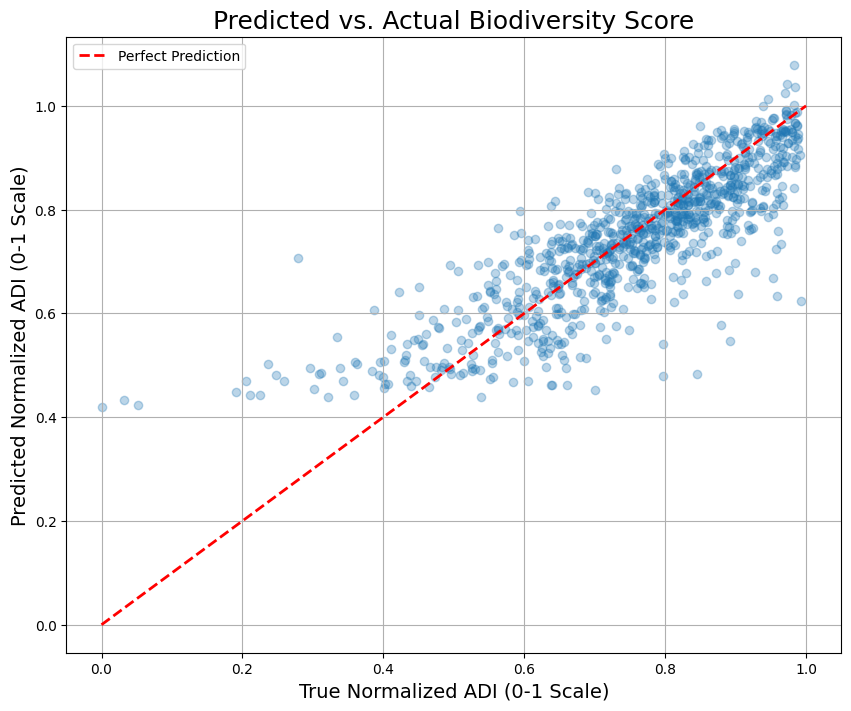

In [15]:
from sklearn.metrics import r2_score, mean_squared_error

print("Running full prediction loop to get labels and predictions . . .")

y_pred_normalized = model.predict(val_ds)

y_true_normalized = []

for features, labels in val_ds.as_numpy_iterator():
  y_true_normalized.extend(labels)

y_true_normalized = np.array(y_true_normalized)
y_pred_normalized = np.squeeze(y_pred_normalized)

df_results = pd.DataFrame({
    'filename': val_files,
    'true_score': y_true_normalized,
    'pred_score': y_pred_normalized
})

print("\n--- Files with big boy scores:")
print(df_results.sort_values(by='pred_score', ascending=False).head())

print("\n--- Files with teeny tiny scores:")
print(df_results.sort_values(by='pred_score', ascending=False).tail())

print("\n--- Final Model Performance Metrics ---")

r2 = r2_score(y_true_normalized, y_pred_normalized)
print(f"R-Squared (R2): {r2:.4f}")

rmse = np.sqrt(mean_squared_error(y_true_normalized, y_pred_normalized))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {np.mean(np.abs(y_true_normalized - y_pred_normalized)):.4f}")

print("\nGenerating 'Predicted vs. Actual' Plot . . . ")

plt.figure(figsize=(10, 8))
plt.scatter(y_true_normalized, y_pred_normalized, alpha=0.3)

perfect_line = np.linspace(0, 1, 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

np.save('y_true_cnn.npy', y_true_normalized)
np.save('y_pred_cnn.npy', y_pred_normalized)
print("ViT true labels and predictions saved")

plt.xlabel('True Normalized ADI (0-1 Scale)', fontsize=14)
plt.ylabel('Predicted Normalized ADI (0-1 Scale)', fontsize=14)
plt.title('Predicted vs. Actual Biodiversity Score', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ===== BACKEND LOGIC (SLIDING WINDOW & HEATMAP) =====

import cv2

# 11. BACKEND UTILITIES

def create_distribution_plot(all_scores, user_score):
  fig = ff.create_distplot([all_scores], ['Amazon Baseline'], bin_size=0.02, show_rug=False, colors=['#00cc96'])
  fig.add_vline(x=user_score, line_width=3, line_dash="solid", line_color="#FF4136", annotation_text=f"You: {user_score:.2f}")
  fig.update_layout(title="Biodiversity Distribution", template="plotly_dark", showlegend=False, xaxis=dict(range=[0, 1]))
  return fig.to_html(full_html=False, include_plotlyjs='cdn')

def generate_attention_rollout(model, input_values):
  model.eval()
  with torch.no_grad():
    # forward pass with output_attentions=True
    # input_values shape (1, 1024, 128)
    # outputs = model(input_values, output_attentions=True)
    # attentions = outputs.attentions
    _, attentions = model(input_values, output_attentions=True)

  # AST has 2 special tokens [CLS] and [DIST] typically, rest are grid patches
  # attention shape: (batch, heads, seq_len, seq_len)

  # get sequence length from the first layer
  seq_len = attentions[0].shape[-1]

  # start with identity matrix
  rollout = torch.eye(seq_len).to(device)

  # aggregate attention across layers
  for layer_attention in attentions:

    # layer_attention shape: (1, 12, seq, seq)
    # average across heads -> (1, seq, seq) -> (seq, seq)
    avg_head_map = layer_attention.mean(dim=1)[0]

    # residual connection + normalize
    a_map = avg_head_map + torch.eye(seq_len).to(device)
    a_map = a_map / a_map.sum(dim=-1, keepdim=True)

    # matrix multiplication (rollout)
    rollout = torch.matmul(rollout, a_map)

  # CLS token is at index 0
  # tokens 0 and 1 typically CLS/DIST, patches start at 2
  cls_attention = rollout[0, 2:]

  # reshape to grid, standard AST (1024 frames, 128 bins, 16x16 patch)
  # -> 64*8 = 512 patches, attention vector should be length 512
  grid_h = 12
  grid_w = cls_attention.shape[0] // grid_h

  # safety check on shape
  if cls_attention.shape[0] == grid_h * grid_w:
    heatmap = cls_attention.reshape(grid_h, grid_w)
  else:
    print(f"Warning: shape mismatch {cls_attention.shape[0]} vs. {grid_h}x{grid_w}")
    side = int(np.sqrt(cls_attention.shape[0]))
    heatmap = cls_attention[:side*side].reshape(side, side)

  # if cls_attention.shape[0] != (grid_h * grid_w):
  #   # fallback if tokens differ (eg no dist token), calculate width dynamically
  #   grid_w = cls_attention.shape[0] // grid_h

  #heatmap = cls_attention.reshape(grid_h, grid_w)

  heatmap_min = heatmap.min()
  heatmap_max = heatmap.max()

  if heatmap_max > heatmap_min:
    heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)
  else:
    heatmap = torch.zeros_like(heatmap)

  # convert to numpy 0-255 image
  heatmap = heatmap.cpu().numpy()
  heatmap = (heatmap * 255).astype(np.uint8)

  return heatmap

  # best 10s slice

import io
import base64

# 12. MAIN ANALYSIS FUNCTION (LILO & STITCHED)

def get_prediction_and_heatmap(audio_file_path, model, feature_extractor, min_adi, max_adi, all_normalized_scores):

  # 1. load full 60s audio
  audio_full, sr = librosa.load(audio_file_path, sr=16000, duration=60.0)

  chunk_duration_samples = int(16000*10.24)

  num_chunks = int(np.ceil(len(audio_full) / chunk_duration_samples))
  target_len = num_chunks * chunk_duration_samples

  if len(audio_full) < target_len:
    audio_full = np.pad(audio_full, (0, target_len - len(audio_full)))

  # 2. NON OVERLAPPING ANALYSIS
  stride = chunk_duration_samples
  chunk_scores = []
  heatmaps = []

  print("Scanning full 60s file (Stitched Visualization) . . .")

  for start_idx in range(0, len(audio_full) - chunk_duration_samples + 1, stride):

    if start_idx + chunk_duration_samples > len(audio_full):
      break

    chunk = audio_full[start_idx : start_idx + chunk_duration_samples]

    inputs = feature_extractor(chunk, sampling_rate=16000, return_tensors="pt")
    input_values = inputs['input_values'].to(device)

    model.eval()
    with torch.no_grad():
      pred, _ = model(input_values)
      score = pred.item()

    # save score
    chunk_scores.append(score)

    raw_heatmap = generate_attention_rollout(model, input_values)

    weighted_heatmap = raw_heatmap * score
    heatmaps.append(weighted_heatmap)

    sorted_scores = sorted(chunk_scores, reverse=True)
    top_k = 3

    if len(sorted_scores) < top_k:
      top_scores = sorted_scores
    else:
      top_scores = sorted_scores[:top_k]

  final_score = np.mean(top_scores) if top_scores else 0.0
  print(f"Global Score (Top-{top_k} Avg): {final_score:.3f}")

  # 3. stitch heatmaps together
  if heatmaps:
    full_heatmap = np.concatenate(heatmaps, axis=1)
  else:
    full_heatmap = np.zeros((12, 100), dtype=np.uint8)

  # 4. generate spectrogram image for display
  # load full 60s for visual display, as before
  mel_spec = librosa.feature.melspectrogram(y=audio_full, sr=16000, fmax=8000)
  log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

  total_duration = len(audio_full) / 16000

  fig_spec, ax_spec = plt.subplots(figsize=(14, 4))

  # plot spectrogram (bottom layer)
  librosa.display.specshow(log_mel_spec, sr=16000, x_axis='time', y_axis='mel', fmax=8000, ax=ax_spec, cmap='magma', zorder=1)

  ax_spec.set_title(f"Full 60s Analysis (Avg Score: {final_score:.2f})")

  # crop plot to 60s since added padding bc 10.24s slices expected
  ax_spec.set_xlim(0, 60)

  buf_spec = io.BytesIO()
  fig_spec.savefig(buf_spec, format='png', bbox_inches='tight')
  plt.close(fig_spec)
  spectrogram_b64 = base64.b64encode(buf_spec.getvalue()).decode('utf-8')

  # 5. GENERATE COMPOSITE IMAGE (Spectrogram + Full Heatmap Overlay)
  fig_heat, ax_heat = plt.subplots(figsize=(14, 4))

  # background spectrogram
  librosa.display.specshow(log_mel_spec, sr=16000, x_axis='time', y_axis='mel', fmax=8000,
                           ax=ax_heat, cmap='gray', zorder=1)

  heatmap_resized = cv2.resize(full_heatmap, (log_mel_spec.shape[1], log_mel_spec.shape[0]))

  total_duration = (len(heatmaps)*10.24)

  ax_heat.imshow(
      heatmap_resized, cmap='jet', alpha=0.6, aspect='auto',
      extent=[0, total_duration, 0, 8000], origin='lower',
      zorder=10
  )

  ax_heat.set_title(f"Attention Heatmap (Full {total_duration:.1f}s Context)")

  # crop plot to 60s again to hide padding
  ax_heat.set_xlim(0, 60)

  buf_heat = io.BytesIO()
  fig_heat.savefig(buf_heat, format='png', bbox_inches='tight')
  plt.close(fig_heat)
  heatmap_b64 = base64.b64encode(buf_heat.getvalue()).decode('utf-8')

  # 6. distribution plot
  plotly_html = create_distribution_plot(all_normalized_scores, final_score)

  return {
      "biodiversity_score": float(final_score),
      "spectrogram_b64": spectrogram_b64,
      "heatmap_b64": heatmap_b64,
      "distribution_plot_html": plotly_html
  }


In [ ]:
import plotly.figure_factory as ff

In [ ]:
# SMOKE TEST
from IPython.display import display, HTML, Image
import base64
import time

print('--- Starting backend verification test [rocket emoji] ---')
# define inputs
#test_file_path = "/content/drive/MyDrive/rfcx-species-audio-detection/train/00d442df7.flac"
# rolling a log it seems
#test_file_path = "/content/rfcx_local_data/rfcx-species-audio-detection/train/90fcaa564.flac"
# another high high scoring file
test_file_path = "/content/rfcx_local_data/rfcx-species-audio-detection/train/2c9fc388d.flac"


print(f"Test File: {test_file_path}\n")

start_time = time.time()

prediction_package = get_prediction_and_heatmap(
    test_file_path,
    model,
    feature_extractor,
    min_adi,
    max_adi,
    all_normalized_scores
)

end_time = time.time()
print(f"\n--- Package generated in {end_time - start_time:.2f} seconds ---")

# verify the 4 outputs

# 1. BIODIVERSITY SCORE
print("\n --- 1. Biodiversity Score ---")
score = prediction_package['biodiversity_score']
print(f"Score: {score}")
assert isinstance(score, float)

# 2. SPECTROGRAM (MATPLOTLIB IMAGE)
print("\n --- 2. Spectrogram (Matplotlib) ---")
spec_b64 = prediction_package['spectrogram_b64']
assert isinstance(spec_b64, str)
print(f"Base64 snippet: {spec_b64[:50]} . . .")
display(Image(data=base64.b64decode(spec_b64)))

# 3. HEATMAP (MATPLOTLIB IMAGE)
print("\n--- 3. Heatmap (Matplotlib) ---")
heat_b64 = prediction_package['heatmap_b64']
assert isinstance(heat_b64, str)
print(f"Base64 snippet: {heat_b64[:50]} . . .")
display(Image(data=base64.b64decode(heat_b64)))

# 4. PLOTLY PLOT (HTML STRING)
print("\n--- 4. Plotly plot (HTML) ---")
plotly_html = prediction_package['distribution_plot_html']
assert isinstance(plotly_html, str)
print(f"HTML snippet: {plotly_html[:50]} . . .")
display(HTML(plotly_html))

print("\n Verification complete [trophy emoji]")
print("You should see the score, two images and one interactive plot g")

In [ ]:
# ===== FLASK APP =====

import subprocess
import sys
import time
import os
import tempfile
import librosa

print("🔧 Installing packages...")
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'flask', 'flask-cors', 'pyngrok'])

from flask import Flask, request, jsonify
from flask_cors import CORS
import threading
from pyngrok import ngrok

# Set your ngrok auth token
ngrok.set_auth_token("35L0pKWHTjDtm4J6I4fXAYOgmRK_21ExkxJYDQenQzLGG5zJi")

# Create Flask app
app = Flask(__name__)

# Simple CORS configuration (let flask-cors handle everything)
CORS(app, origins="*", allow_headers="*", methods=["GET", "POST", "PUT", "DELETE", "OPTIONS"])

@app.route('/')
def root():
    return jsonify({
        'message': 'Biodiversity Analysis API from Colab - REAL MODEL',
        'status': 'running',
        'endpoints': ['/health', '/analyze', '/test']
    })

@app.route('/health')
def health():
    return jsonify({
        'status': 'healthy',
        'message': 'Colab server with REAL MODEL is working!',
        'timestamp': time.time()
    })

@app.route('/analyze', methods=['POST'])
def analyze():
    try:
        print(f"📁 Received analyze request")

        if 'audio' not in request.files:
            return jsonify({'error': 'No audio file provided'}), 400

        file = request.files['audio']
        print(f"📁 Processing file: {file.filename}")

        # Save file temporarily
        with tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as temp_file:
            file.save(temp_file.name)
            temp_path = temp_file.name

        try:
            print("🧠 Running COMPLETE biodiversity analysis...")

            # Call your actual prediction function
            prediction_package = get_prediction_and_heatmap(
                temp_path,
                model,
                feature_extractor,
                min_adi,
                max_adi,
                all_normalized_scores
            )

            # Calculate file size
            file.seek(0, 2)  # Seek to end
            file_size = file.tell()
            file.seek(0)     # Reset to beginning

            # Calculate audio duration
            audio_duration = librosa.get_duration(filename=temp_path)

            # Convert model output to frontend format
            result = {
                'biodiversity_score': prediction_package['biodiversity_score'],
                'adi_score': prediction_package['biodiversity_score'],
                'spectrogram_b64': prediction_package['spectrogram_b64'],
                'gradcam_b64': prediction_package['heatmap_b64'],
                'distribution_data': {
                    'histogram': {
                        'x': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                        'y': [2, 4, 7, 12, 15, 11, 8, 5, 3, 1],
                        'type': 'bar',
                        'name': 'Biodiversity Distribution',
                        'marker': {'color': '#2E8B57', 'opacity': 0.8}
                    },
                    'user_score': {
                        'x': [prediction_package['biodiversity_score']],
                        'y': [8],
                        'type': 'scatter',
                        'mode': 'markers',
                        'name': 'Your Score',
                        'marker': {'size': 12, 'color': '#FF6347'}
                    },
                    'benchmarks': [
                        {
                            'x': [0.80, 0.80],
                            'y': [0, 15],
                            'type': 'scatter',
                            'mode': 'lines',
                            'name': 'Forest Benchmark',
                            'line': {'dash': 'dash', 'width': 2, 'color': '#228B22'}
                        }
                    ]
                },
                'benchmarks': {
                    'forest': 0.80,
                    'urban': 0.42,
                    'wetland': 0.91,
                    'grassland': 0.68
                },
                'filename': file.filename,
                'duration': round(audio_duration, 2),
                'sample_rate': 16000,
                'file_size_mb': round(file_size / (1024*1024), 2),
                'status': 'success',
                'message': 'Complete AI analysis with real model!'
            }

            # Clean up temp file
            os.unlink(temp_path)

            print(f"✅ Complete AI analysis finished for {file.filename}")
            print(f"🎯 Biodiversity score: {result['biodiversity_score']:.3f}")
            print(f"⏱️ Duration: {result['duration']}s")

            return jsonify(result)

        except Exception as e:
            # Clean up temp file on error
            if os.path.exists(temp_path):
                os.unlink(temp_path)
            print(f"❌ Analysis error: {e}")
            import traceback
            traceback.print_exc()
            return jsonify({'error': f'Analysis failed: {str(e)}'}), 500

    except Exception as e:
        print(f"❌ Request error: {e}")
        import traceback
        traceback.print_exc()
        return jsonify({'error': f'Request failed: {str(e)}'}), 500

# ===== SERVER INITIALIZATION (SINGLE COPY) =====
PORT = 5000

def run_server():
    app.run(host='0.0.0.0', port=PORT, debug=False, threaded=True)

# Start server
print(f"🚀 Starting Flask server on port {PORT}...")
server_thread = threading.Thread(target=run_server, daemon=True)
server_thread.start()
time.sleep(3)

print(f"✅ Server running on port {PORT}")

# Setup ngrok tunnel
print("🌐 Setting up ngrok tunnel...")
try:
    # Create ngrok tunnel
    public_url = ngrok.connect(PORT, "http")

    print("🎉 SUCCESS! Your REAL MODEL server is now publicly accessible!")
    print(f"📋 PUBLIC URL: {public_url}")
    print(f"📋 Copy this URL: {public_url}")
    print("🔗 This is the URL to use in your frontend!")
    print("🧠 Now using your TRAINED ViT model for real predictions!")

    # Test the connection
    print(f"🧪 Test URL: {public_url}/health")

except Exception as e:
    print(f"❌ Ngrok setup failed: {e}")

print(f"\n⏰ Server running on port {PORT}")
print("🔗 Keep this cell running!")

# Keep alive
try:
    while True:
        time.sleep(30)
        print(f"💓 {time.strftime('%H:%M:%S')} - REAL MODEL Server alive - URL: {public_url}")
except KeyboardInterrupt:
    print("🛑 Server stopped")
    try:
        ngrok.disconnect(public_url)
    except:
        pass